In [ ]:
import torch.nn as nn
import torch


class LSTM_base(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTM_base, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch, depth, seq_len, feat_dim = x.shape
        
        x = x.reshape(batch * depth, seq_len, feat_dim)
        lstm_out, hidden = self.lstm(x)
        out = self.fc(lstm_out)
        out = out.reshape(batch, depth, seq_len, 1).squeeze()
        return out
    
    
class LSTM_depth_rnn_spatial(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTM_depth_rnn_spatial, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = hidden_dim * 2, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        
        self.depth_lstm = nn.LSTM(input_size = input_dim,
                                  hidden_size = hidden_dim,
                                  num_layers = n_layers,
                                  bidirectional = True,
                                  batch_first = True)
        
        
        self.fc = nn.LazyLinear(output_dim)
        
    def forward(self, x):
        batch, depth, seq_len, feat_dim = x.shape
        
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(batch * seq_len, depth, feat_dim)
        
        depth_out, hid_depth = self.depth_lstm(x)
        depth_out = depth_out.reshape(batch, seq_len, depth, self.hidden_dim * 2)
        depth_out = depth_out.permute(0, 2, 1, 3)
        
        depth_out = depth_out.reshape(batch * depth, seq_len, self.hidden_dim * 2)
        lstm_out, hidden = self.lstm(depth_out)
        out = self.fc(lstm_out)
        out = out.reshape(batch, depth, seq_len, 1).squeeze()
        return out
    
    
class LSTM_depth_rnn_temporal(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTM_depth_rnn_temporal, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        
        self.depth_lstm = nn.LSTM(input_size = hidden_dim,
                                  hidden_size = hidden_dim,
                                  num_layers = n_layers,
                                  bidirectional = True,
                                  batch_first = True)
        
        
        self.fc = nn.LazyLinear(output_dim)
        
    def forward(self, x):
        batch, depth, seq_len, feat_dim = x.shape
        
        x = x.reshape(batch * depth, seq_len, feat_dim)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.reshape(batch, depth, seq_len, self.hidden_dim)
        lstm_out = lstm_out.permute(0, 2, 1, 3)
        
        
        lstm_out = lstm_out.reshape(batch * seq_len, depth, self.hidden_dim)
        depth_out, hid_depth = self.depth_lstm(lstm_out)
        
        out = self.fc(depth_out)
        out = out.reshape(batch, seq_len, depth, 1)
        out = out.permute(0,2,1,3).squeeze()
        
        
        return out
    
class LSTM_attention(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dim, 
                 n_layers, 
                 num_head = 1):
        super(LSTM_attention, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        
        self.attention = nn.MultiheadAttention(embed_dim = hidden_dim, 
                                               num_heads = num_head, 
                                               batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch, depth, seq_len, feat_dim = x.shape
        
        x = x.reshape(batch * depth, seq_len, feat_dim)
        lstm_out, hidden = self.lstm(x)
        
        mask = torch.triu(torch.ones([seq_len, seq_len], dtype=torch.bool), 
                          diagonal=1).to(x.device)
        #mask = ~torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=x.device))
        attn_output, attn_weights = self.attention(query = lstm_out, 
                                      key = lstm_out, 
                                      value = lstm_out,
                                      attn_mask = mask)
        
        out = self.fc(attn_output)
        out = out.reshape(batch, depth, seq_len, 1).squeeze()
        return out

In [ ]:
class LSTM_attention_head_4(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 hidden_dim, 
                 n_layers, 
                 num_head = 1):
        super(LSTM_attention_head_4, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        
        self.attention = nn.MultiheadAttention(embed_dim = hidden_dim, 
                                               num_heads = 4, 
                                               batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch, depth, seq_len, feat_dim = x.shape
        
        x = x.reshape(batch * depth, seq_len, feat_dim)
        lstm_out, hidden = self.lstm(x)
        
        mask = torch.triu(torch.ones([seq_len, seq_len], dtype=torch.bool), 
                          diagonal=1).to(x.device)
        #mask = ~torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=x.device))
        attn_output, attn_weights = self.attention(query = lstm_out, 
                                      key = lstm_out, 
                                      value = lstm_out,
                                      attn_mask = mask)
        
        out = self.fc(attn_output)
        out = out.reshape(batch, depth, seq_len, 1).squeeze()
        return out

In [ ]:
import os, random, warnings
import numpy as np
import pandas as pd
import sys

import torch

import warnings
warnings.filterwarnings("ignore")

import json

def load_json(path):
    with open(path) as f:
        config = json.load(f)
    return config

def dump_json(config, path):
    with open(path, 'w') as f:
        json.dump(config, f, indent=4)


def main(args):
    
    sys.path.append(args['code_path'])
    
    
    import models
    
    from loss import LakeLoss
    from trainer import Trainer
    from dataset import get_dataloader


    
    data_dir = args['data_dir']
    device = args['device']
    
    seed = args['seed']

    np.random.seed(seed)
    torch.manual_seed(seed)
    

    strides = args['strides']
    window_size = args['window_size']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    
    ec_loss_flag = args['ec_loss']
    
    model = globals()[args['model_name']](input_dim = 9, 
                                                output_dim = 1, 
                                                hidden_dim = args['hidden_dim'], 
                                                n_layers = 1)
    
    
    result = {}
    
    if args['pre_train']:
        tr_loader, va_loader, full_loader, te_loader = get_dataloader(path = data_dir, 
                                                              window_size = window_size,
                                                              strides = strides,
                                                              batch_size = batch_size,
                                                              mask_rate = 0,
                                                              simulate = True,
                                                              )
        trainer = Trainer(device = device, learning_rate=learning_rate)
        loss_func = LakeLoss(ec_loss = ec_loss_flag, device = device)
        
        model, epoch_info = trainer(model, loss_func, tr_loader, va_loader)

        trainer.epochs = epoch_info['epoch_no']
        trainer.early_stopping_patience = 100
        model = globals()[args['model_name']](input_dim = 9, 
                                                output_dim = 1, 
                                                hidden_dim = args['hidden_dim'], 
                                                n_layers = 1)
        
        model, epoch_info_retrain = trainer(model, loss_func, full_loader, full_loader)
        
    import tempfile
    temp_dir = tempfile.TemporaryDirectory(prefix="ts-temp-")
    path = f"{temp_dir.name}_best_model.pt"
    torch.save(model.state_dict(), path)

        
    tr_loader, va_loader, full_loader, te_loader = get_dataloader(path = data_dir, 
                                                              window_size = window_size,
                                                              strides = strides,
                                                              batch_size = batch_size,
                                                              mask_rate = args['mask_rate'],
                                                              simulate = False,
                                                              )
        
    if args['real_train']:
        loss_func = LakeLoss(ec_loss = ec_loss_flag, device = device)
        trainer = Trainer(device = device, learning_rate = learning_rate)

        model, epoch_info = trainer(model, loss_func, tr_loader, va_loader)
        
        
#         model = getattr(models, args['model_name'])(input_dim = 9, 
#                                                 output_dim = 1, 
#                                                 hidden_dim = args['hidden_dim'], 
#                                                 n_layers = 1)
    
#         model.load_state_dict(torch.load(path))
#         trainer.epochs = epoch_info['epoch_no']
#         trainer.early_stopping_patience = 100
#         model, epoch_info_retrain = trainer(model, loss_func, full_loader, full_loader)


        
    from utils import model_inference
    
    test_loss, test_time = model_inference(model, te_loader, device = device)
    print('Fine-tune test loss is:', test_loss)
    args['real_loss'] = test_loss
    
    return model, te_loader, args
        
        

In [ ]:
config_temp = {
    'data_dir': '../Data',
    'code_path': '../src/',
    'pre_train': True,
    'real_train':True,
    'model_name':'LSTM_depth_rnn_temporal',
    'hidden_dim': 8,
    'learning_rate': 1e-2,
    'strides':4,
    'window_size':64,
    'batch_size':64,
    'mask_rate': 0.,
    'ec_loss': True,
    'seed': 1,
    'device': 'cuda:0',
    'output_dir': '../output_6'
}
model_temporal, te_loader, args = main(config_temp)

2022-03-09 02:36:02 INFO:113] Epoch[0] Elapsed time 0.599 seconds
2022-03-09 02:36:02 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=11.1697
2022-03-09 02:36:03 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=8.9443
2022-03-09 02:36:22 INFO:113] Epoch[10] Elapsed time 0.597 seconds
2022-03-09 02:36:22 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.5234
2022-03-09 02:36:23 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.5846
2022-03-09 02:36:43 INFO:113] Epoch[20] Elapsed time 0.594 seconds
2022-03-09 02:36:43 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.1543
2022-03-09 02:36:44 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.3173
2022-03-09 02:37:00 INFO:67] Early Stopping.
2022-03-09 02:37:01 INFO:113] Epoch[0] Elapsed time 0.594 seconds
2022-03-09 02:37:01 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=11.4218
2022-03-09 02:37:02 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=10.1614
2022-03-09 02:37:22 IN

Fine-tune test loss is: 1.5572118408539717


In [ ]:
config_base = {
    'data_dir': '../Data',
    'code_path': '../src/',
    'pre_train': True,
    'real_train':True,
    'model_name':'LSTM_base',
    'hidden_dim': 8,
    'learning_rate': 1e-2,
    'strides':4,
    'window_size':64,
    'batch_size':64,
    'mask_rate': 0.,
    'ec_loss': True,
    'seed': 1,
    'device': 'cuda:0',
    'output_dir': '../output_6'
}
model_base, te_loader, args = main(config_base)

2022-03-08 11:46:01 INFO:113] Epoch[0] Elapsed time 0.466 seconds
2022-03-08 11:46:01 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=11.8798
2022-03-08 11:46:02 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=10.6281
2022-03-08 11:46:11 INFO:113] Epoch[10] Elapsed time 0.464 seconds
2022-03-08 11:46:11 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=3.3475
2022-03-08 11:46:11 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=2.9207
2022-03-08 11:46:21 INFO:113] Epoch[20] Elapsed time 0.471 seconds
2022-03-08 11:46:21 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.4544
2022-03-08 11:46:21 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.5246
2022-03-08 11:46:31 INFO:113] Epoch[30] Elapsed time 0.467 seconds
2022-03-08 11:46:31 INFO:117] Epoch[30] Evaluation metric 'epoch_loss'=1.1734
2022-03-08 11:46:31 INFO:117] Epoch[30] Evaluation metric 'validation_epoch_loss'=1.3557
2022-03-08 11:46:37 INFO:67] Early Stopping.
2022-03-08 11:46:37 

Fine-tune test loss is: 1.5461277470869177


In [ ]:
config = {
    'data_dir': '../Data',
    'code_path': '../src/',
    'pre_train': True,
    'real_train':True,
    'model_name':'LSTM_depth_rnn_spatial',
    'hidden_dim': 16,
    'learning_rate': 1e-2,
    'strides':4,
    'window_size':64,
    'batch_size':64,
    'mask_rate': 0.,
    'ec_loss': True,
    'seed': 1,
    'device': 'cuda:0',
    'output_dir': '../output_6'
}

model, te_loader, args = main(config)

2022-03-07 17:26:39 INFO:113] Epoch[0] Elapsed time 0.663 seconds
2022-03-07 17:26:39 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.4484
2022-03-07 17:26:39 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.9655
2022-03-07 17:26:51 INFO:113] Epoch[10] Elapsed time 0.653 seconds
2022-03-07 17:26:51 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.5687
2022-03-07 17:26:51 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.5740
2022-03-07 17:27:03 INFO:113] Epoch[20] Elapsed time 0.651 seconds
2022-03-07 17:27:03 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.1156
2022-03-07 17:27:03 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2847
2022-03-07 17:27:12 INFO:67] Early Stopping.
2022-03-07 17:27:13 INFO:113] Epoch[0] Elapsed time 0.649 seconds
2022-03-07 17:27:13 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.7000
2022-03-07 17:27:13 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=9.2473
2022-03-07 17:27:25 INF

Fine-tune test loss is: 1.3913315043729895


In [ ]:
from tqdm import tqdm

from utils import data_split,read_data

import gc

full_dict = read_data(args['data_dir'], simulate = False)
train_dict, valid_dict, train_full_dict, test_dict = data_split(full_dict)

del full_dict, train_dict, valid_dict, train_full_dict;gc.collect();

label = test_dict['label']

label_pred_spatial = np.zeros(test_dict['label'].shape)
label_pred_base = np.zeros(test_dict['label'].shape)
label_pred_temporal = np.zeros(test_dict['label'].shape)

loc = 0

data_x = test_dict['x']
window_size = args['window_size']
strides = args['strides']

device = next(model.parameters()).device

while loc + window_size < data_x.shape[1]:

    tmp_array = data_x[:, loc: loc + window_size]
    tmp_array = np.expand_dims(tmp_array, axis = 0)
    with torch.no_grad():
        pred = model(torch.tensor(tmp_array.astype(np.float32)).to(device))
        label_pred_spatial[:, loc: loc + window_size] = pred.cpu().numpy()
    
        pred_base = model_base(torch.tensor(tmp_array.astype(np.float32)).to(device))
        label_pred_base[:, loc: loc + window_size] = pred_base.cpu().numpy()
        
        pred_temp = model_temporal(torch.tensor(tmp_array.astype(np.float32)).to(device))
        label_pred_temporal[:, loc: loc + window_size] = pred_temp.cpu().numpy()
    
    loc += strides

In [ ]:
sim_dict_test = read_data(args['data_dir'], simulate = True)

sim_label = sim_dict_test['label'][-weight.shape[1]:]

In [ ]:
weight = test_dict['mask']

depth_spatial = np.sqrt(np.sum(weight * (label - label_pred_spatial) ** 2, 
                               axis = 1) / (1e-3 +np.sum(weight, axis = 1)))
depth_base = np.sqrt(np.sum(weight * (label - label_pred_base) ** 2, 
                            axis = 1) / (1e-3 +np.sum(weight, axis = 1)))

depth_temporal = np.sqrt(np.sum(weight * (label - label_pred_temporal) ** 2, 
                               axis = 1) / (1e-3 +np.sum(weight, axis = 1)))


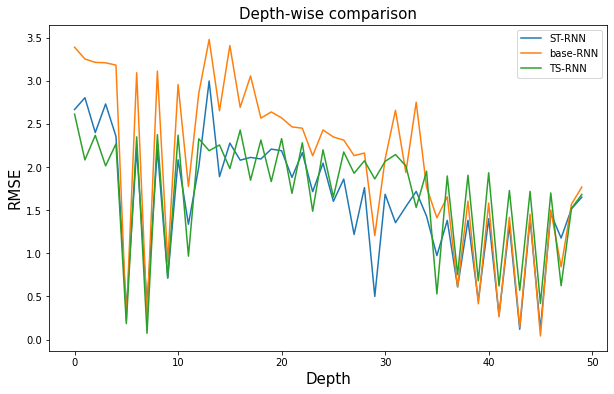

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.title("Depth-wise comparison", fontsize = 15)
plt.plot(depth_spatial, label = "ST-RNN")
plt.plot(depth_base, label = "base-RNN")
plt.plot(depth_temporal, label = "TS-RNN")
plt.xlabel("Depth", fontsize = 15)
plt.ylabel("RMSE", fontsize = 15)
plt.legend()

In [ ]:
weight.mean(axis = 0).argsort()[-20:]

array([ 442,  120,  492, 2683,  414,  464,  792,   64, 1121,   93, 1849,
        765,   78,   53,  820, 1163,  386, 1443,   36,   22])

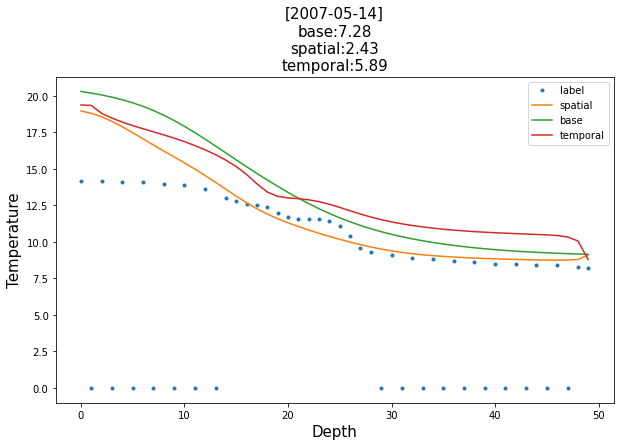

In [ ]:
dates_arr = np.load(args['data_dir'] + '/dates.npy')[-weight.shape[1]:]
dates_d = dates_arr.astype('M8[D]') ## transform the dates to date
dates_m = dates_arr.astype('M8[M]') ## transform the dates to date
dates_y = dates_arr.astype('M8[Y]') ## transform the dates to year
# load features

idx_used = 1443

s = pd.to_datetime(dates_arr[idx_used]).date().isoformat()
base_l = np.sum(weight[:, idx_used] * (label[:,idx_used] - label_pred_base[:,idx_used]) ** 2)/np.sum(weight[:, idx_used])
spatial_l = np.sum(weight[:, idx_used] * (label[:,idx_used] - label_pred_spatial[:,idx_used]) ** 2)/np.sum(weight[:, idx_used])
temporal_l = np.sum(weight[:, idx_used] * (label[:,idx_used] - label_pred_temporal[:,idx_used]) ** 2)/np.sum(weight[:, idx_used])
plt.figure(figsize = (10,6))
plt.title(f"[{s}]\n\
base:{np.round(base_l,2)}\n\
spatial:{np.round(spatial_l,2)}\n\
temporal:{np.round(temporal_l,2)}", fontsize = 15)
plt.plot(label[:,idx_used], label = 'label', marker = ".", linestyle='None')
# plt.plot(sim_label[:,idx_used], label = 'sim_label')
plt.plot(label_pred_spatial[:,idx_used], label = 'spatial')
plt.plot(label_pred_base[:,idx_used], label = 'base')
plt.plot(label_pred_temporal[:,idx_used], label = 'temporal')
plt.xlabel("Depth", fontsize = 15)
plt.ylabel("Temperature", fontsize = 15)
plt.legend()